# Homework 3 - EECS 600 Deep Learning

Name: 

Instructions: All assignments are to be completed individually. Please complete each question as best you can. Once you have completed all of the problems, reset your runtime or kernel and run the notebook in order. Download the .ipynb file and submit it via Canvas.

Library usage: Several of the algorithms implemented in this, and other assignments, have implementations available in tensorflow. For this assignment, you may use any of the functionality within tensorflow.

All code presented in class is free to use in your assignments.

Your grade is based on the correctness of your implementation, not the quality of your code but you are encouraged to include comments in your code to help the graders understand your decisions.

For clarity, the final operation you should take is restarting the runtime and running all.

Due Date: 12/6/19 - midnight EST

100 Points Total

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, activations, optimizers
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tf.enable_eager_execution()

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = (train_images / 127.5) - 1
train_images = train_images.reshape((*train_images.shape, 1))
test_images = (test_images / 127.5) - 1
test_images = test_images.reshape((*test_images.shape, 1))

In [3]:
train_images.shape

(60000, 28, 28, 1)

Loading the dataset returns four NumPy arrays:

The train_images and train_labels arrays are the training set—the data the model uses to learn.
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

Label |	Class
------|------
0 |	T-shirt/top
1 |	Trouser
2 |	Pullover
3 |	Dress
4 |	Coat
5 |	Sandal
6 |	Shirt
7 |	Sneaker
8 |	Bag
9 |	Ankle boot

Each image is mapped to a single label. Since the class names are not included with the dataset.

More information and a working example using this dataset here: https://www.tensorflow.org/tutorials/keras/classification.

## Recommendation
When building and testing your code, work on a smaller subset of the data. [This example](https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array) may help in that.


# Question 1
Implement a Deep Convolutional Generative Adversarial Network for generating fasion MNIST photos.

## Implementation of DCGAN

In this part, we implemented DCGAN with `keras`. The network structure was from the original paper by Alec Radford et al. with slight modification and size reduction.

Here are a list of reference materials that we used along the implementation.
- [Original DCGAN Paper by Alec Radford et al.](https://arxiv.org/abs/1511.06434)
- [`PyTorch` DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
- [DCGAN for Bird Generation by Github User Goldesel23](https://github.com/Goldesel23/DCGAN-for-Bird-Generation)

In [4]:
def generator():
    m = models.Sequential()
    m.add(layers.InputLayer(input_shape=100))
    m.add(layers.Dense(7*7*256))
    m.add(layers.Reshape((7,7,256)))
    m.add(layers.BatchNormalization())
    m.add(layers.ReLU())

    def add_convt_bn(filters, kernel_size, strides):
        m.add(layers.Conv2DTranspose(filters, kernel_size, strides, padding="same", use_bias=False))
        m.add(layers.BatchNormalization())
        m.add(layers.ReLU())
    
    block_size = [
                  (256, 5, 1),
                  (128, 5, 1),
                  (64, 5, 2),
    ]    
    
    for s in block_size:
        add_convt_bn(*s)
    
    m.add(layers.Conv2DTranspose(1, 5, 2, padding="same", use_bias=False))
    m.add(layers.Activation("tanh"))
    
    return m

generator().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 256)         1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 256)         1638400   
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 256)         0

In [5]:
def discriminator():
    m = models.Sequential()
    m.add(layers.InputLayer((28, 28, 1)))

    def add_conv_bn(filters, kernel_size, strides):
        m.add(layers.Conv2D(filters, kernel_size, strides, padding="same", use_bias=False))
        m.add(layers.BatchNormalization(momentum=0.5))
        m.add(layers.LeakyReLU(alpha=0.2))

    block_size = [
                  (256, 5, 1),
                  (128, 5, 2),
                  (64, 5, 2),
    ]

    for s in reversed(block_size):
        add_conv_bn(*s)

    m.add(layers.Flatten())
    m.add(layers.Dense(100, "relu"))
    m.add(layers.Dense(1, "sigmoid"))

    m.compile(
        loss="binary_crossentropy",
        optimizer = optimizers.Adam(lr=0.0004, beta_1=0.5),
    )

    return m

discriminator().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1600      
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204800    
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)        

**On Implementing GAN Trainer**

`GANTrainer` took two models, the discriminator $D$ and generator $G$ and a dataset as input. Internally, it uses a sequential model $GAN$ to put the $G$ and $D$ in series.

We first train $D$ on real data and generated fake data to consolidate $D$'s ability to distinguish fake data from real data. 

Then we use the aforementioned GAN model and train it as a whole for easier implemention. In this process, we set `D.trainable` to `False` such that the loss will not be propagated to $D$ and only $G$ is updated. We expect (and train) $GAN$, on inputs of random latent vectors, outputs real label.

In [6]:
REAL_LABEL = 1.0
FAKE_LABEL = 0.0

class GANTrainer:

    def __init_GAN__(self):
        self.GAN = models.Sequential()
        self.D.trainable=False
        self.GAN.add(self.G)
        self.GAN.add(self.D)
        self.GAN.compile(
            loss="binary_crossentropy",
            optimizer = optimizers.Adam(lr=0.0006, beta_1=0.6),
        )

    def __init__(self, D, G, train_dataset):
        self.D = D        
        self.G = G
        self.__init_GAN__()
        self.train_dataset = train_dataset
        
        self.d_train_history = []
        self.g_train_history = []
    
    def train_on_batch(self, real_X):
        ##############################
        # Update Discriminator
        ##############################
        self.D.trainable = True
        batch_size = tf.shape(real_X)[0]

        # train on real data with noisy label
        real_y = tf.fill((batch_size,), REAL_LABEL) - tf.random_uniform((batch_size,)) * 0.2
        dmetrics = self.D.train_on_batch(real_X, real_y, reset_metrics=False)

        # train on fake data
        noise = tf.random_normal(shape=(batch_size, 100))
        fake_X = self.G(noise)
        fake_y = tf.fill((batch_size,), FAKE_LABEL)
        dmetrics = self.D.train_on_batch(fake_X, fake_y, reset_metrics=False)
        ##############################
        # Update Generator
        ##############################
        # fix D's weights and update G's weights only
        self.D.trainable = False

        noise = tf.random_normal(shape=(batch_size * 2, 100))
        real_y = tf.fill((batch_size*2,), REAL_LABEL)
        gmetrics = self.GAN.train_on_batch(noise, real_y, reset_metrics=False)

        return dmetrics, gmetrics
    
    def train_epoch(self):
        for X, *_ in self.train_dataset:
            self.d_metrics, self.g_metrics = self.train_on_batch(X)
        
        # metrics accumulates
        self.d_train_history.append(self.d_metrics)
        self.g_train_history.append(self.g_metrics)

        self.reset_metrics()

    def reset_metrics(self):
        self.GAN.reset_metrics()
        self.D.reset_metrics()
        self.G.reset_metrics()

In [7]:
from tqdm import tqdm_notebook as tqdm

BATCH_SIZE = 1024

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(10000).batch(BATCH_SIZE)

dcgan = GANTrainer(
    D = discriminator(),
    G = generator(),
    train_dataset = train_ds,
)

In [ ]:
for _ in tqdm(range(150)):
    dcgan.train_epoch()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Plot the loss functions for the generator and discriminator. Label them accordingly

In [57]:
def plot_gan(model, title=None, dpi=100, figsize=[8, 7]):
    fig, axs = plt.subplots(1, 1, sharex=True, dpi=dpi, figsize=figsize)
    fig.suptitle(title)
    num_epochs = len(model.d_train_history)
    
    axs.set_title("Training Loss")
    axs.set_xlabel("Epoch")
    axs.set_ylabel("Loss")
    axs.set_xlim([0, num_epochs])
    axs.set_xticks(range(0, num_epochs + 1, 10))

    def to2d(lis):
        lis = np.asarray(lis)
        lis = lis.reshape((-1, max(lis.shape)))
        return lis
    
    dhist = to2d(model.d_train_history)
    ghist = to2d(model.g_train_history)
    
    dline, *_ = axs.plot(dhist[0], "-.")
    gline, *_ = axs.plot(ghist[0], "-.")

    plt.legend([dline, gline], ["Discriminator", "Generator"])

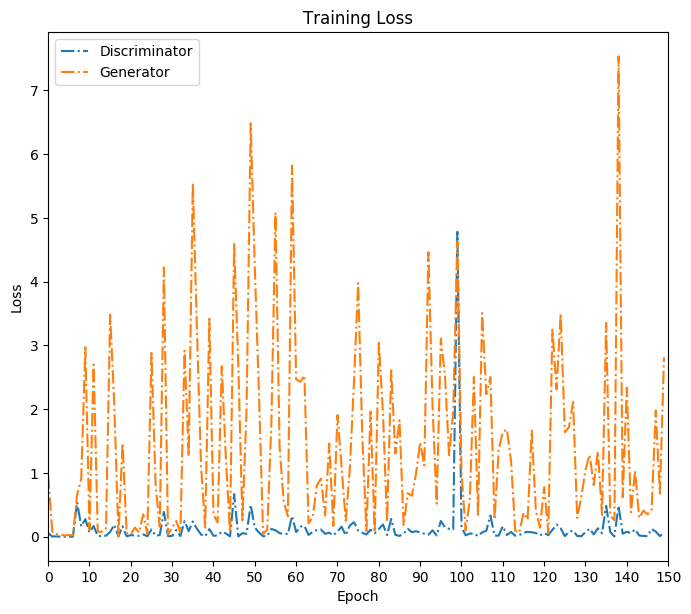

In [58]:
plot_gan(dcgan)

Show three example generated photos using your model. Even though the images may not be perfect, it should be perceivable as a fashion photo.

In [29]:
noise = tf.random_normal(shape=(3, 100))
three_samples = tf.reshape(dcgan.G(noise), (-1, 28, 28))
three_samples = (three_samples + 1) * 127.5

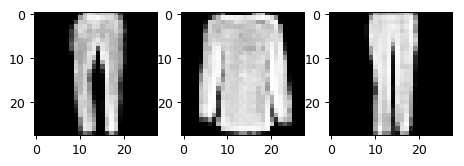

In [30]:
fig, axs = plt.subplots(1, 3, dpi=90)

for i in range(3):
    axs[i].imshow(three_samples[i], cmap="gray")

# Question 2
Design a method to conditionally generate photos of different labels. Pick two classes within the MNIST fasion dataset, and use them to conditionally generate photos of those classes. You will likely need to include another outcome variable in the discriminator to account for this.

## Implementation of ACGAN

Here we implemented an Auxiliary Classifier GAN such that not only the GAN takes an random latent vector, but also a one-hot class identifier as input. 

Some reference materials:
- [Original Paper by Augustus Odena](https://arxiv.org/abs/1610.09585)
- A Blog Article by Machine Learning Mastery, [How to Develop an Auxiliary Classifier GAN (AC-GAN) From Scratch with Keras](https://machinelearningmastery.com/how-to-develop-an-auxiliary-classifier-gan-ac-gan-from-scratch-with-keras/)

In [ ]:
def acdiscriminator():
    m = layers.Input((28, 28, 1), name="D_in")
    m_in = m
    def add_conv_bn(filter_size, kernel_size=(4,4), strides=1, padding="same"):
        l = layers.Conv2D(filter_size, kernel_size, strides, padding=padding, use_bias=False)(m)
        l = layers.BatchNormalization()(l)
        l = layers.LeakyReLU(alpha=0.2)(l)
        return l
    
    block_size = [
                  64, 
                  128, 
                  #256
                  ]
    for s in block_size:
        m = add_conv_bn(s)
    
    m = layers.Flatten()(m)

    # discriminator output
    D_m = layers.Dense(1, activation="sigmoid")(m) 
    # classifier output
    C_m = layers.Dense(10, activation="softmax")(m)

    model = models.Model(m_in, [D_m, C_m])
    model.compile(
        loss = ["binary_crossentropy", "sparse_categorical_crossentropy"],
        optimizer = optimizers.Adam(lr=1e-4, beta_1=0.5),
    )
    return model

acdiscriminator().summary()

In [ ]:
def acgenerator():
    # random input
    R_in = layers.Input(100)
    r = layers.Dense(7*7*255)(R_in)
    r = layers.Reshape((7, 7, 255))(r)
    r = layers.BatchNormalization()(r)
    r = layers.ReLU()(r)

    # class input
    C_in = layers.Input(10)
    c = layers.Dense(7*7*1, activation="relu")(C_in)
    c = layers.Reshape((7, 7, 1))(c)

    m = layers.Concatenate()([r, c])

    def add_convt_bn(filter_size, kernel_size=(5,5), strides=1, activation="relu"):
        l = layers.Conv2DTranspose(filter_size, kernel_size, strides, padding="same", use_bias=False)(m)
        l = layers.BatchNormalization()(l)
        l = layers.Activation(activation)(l)
        return l
    
    block_size = [
                  (128, 5, 1),
                  (64, 5, 2),
                  (1, 5, 2, "tanh"),
    ]

    for s in block_size:
        m = add_convt_bn(*s)

    model = models.Model([R_in, C_in], m)
    return model

acgenerator().summary()

**On Implement ACGANTrainer**

Here we used a similar structure of DCGAN, therefore, we made `ACGANTrainer` be a child of `GANTrainer` and specifically override `__init_GAN__`, `train_on_batch` and `train_epoch`.

In [ ]:
class ACGANTrainer(GANTrainer):

    def __init_GAN__(self):
        self.D.trainable=False
        
        gan_output = self.D(self.G.outputs)
        self.GAN = models.Model(self.G.inputs, gan_output)
        self.GAN.compile(
            loss=["binary_crossentropy", "sparse_categorical_crossentropy"],
            optimizer = optimizers.Adam(lr=0.0006, beta_1=0.6),
        )

    def train_on_batch(self, real_X, real_Y):
        ##############################
        # Update Discriminator
        ##############################
        self.D.trainable = True
        batch_size = tf.shape(real_X)[0]

        labels = tf.fill((batch_size,), REAL_LABEL)
        dmetrics = self.D.train_on_batch(real_X, [labels, real_Y], reset_metrics=False)

        # train on fake data
        noise = tf.random_normal(shape=(batch_size, 100))
        cls = tf.random.uniform((batch_size,), minval=0, maxval=10, dtype=tf.int32)
        fake_X = self.G([noise, tf.one_hot(cls, 10)])
        labels = tf.fill((batch_size,), FAKE_LABEL)
        dmetrics = self.D.train_on_batch(fake_X, [labels, cls], reset_metrics=False)

        ##############################
        # Update Generator
        ##############################
        # fix D's weights and update G's weights only
        self.D.trainable = False

        noise = tf.random_normal(shape=(batch_size * 3, 100))
        cls = tf.random.uniform((batch_size * 3,), minval=0, maxval=10, dtype=tf.int32)
        labels = tf.fill((batch_size*3,), REAL_LABEL)
        gmetrics = self.GAN.train_on_batch([noise, tf.one_hot(cls, 10)], [labels, cls], reset_metrics=False)

        return dmetrics, gmetrics
    
    def train_epoch(self):
        for X, y, *_ in self.train_dataset:
            self.d_metrics, self.g_metrics = self.train_on_batch(X, y)
        
        # metrics accumulates
        self.d_train_history.append(self.d_metrics)
        self.g_train_history.append(self.g_metrics)

        self.reset_metrics()

Here we show two classes that we chose for this task. The model we defined is capable of doing all 10 classes all along. However, if we use all data for training, it will take more than ~6 hour to train. 

In [ ]:
def get_train_image(idx):
    return tf.reshape(train_images[idx], (28, 28)), train_labels[idx]

fig, axs = plt.subplots(1, 2, dpi=90)

class_1_img, class_1_label = get_train_image(1992)
axs[0].imshow(class_1_img, cmap='gray')
axs[0].set_title("Label %d" % class_1_label)

class_2_img, class_2_label = get_train_image(9123)
axs[1].imshow(class_2_img, cmap='gray')
axs[1].set_title("Label %d" % class_2_label)

In [ ]:
# select data
class_1_train_images = tf.gather_nd(train_images, tf.where(train_labels == class_1_label))
class_1_train_labels = tf.gather_nd(train_labels, tf.where(train_labels == class_1_label))
class_2_train_images = tf.gather_nd(train_images, tf.where(train_labels == class_2_label))
class_2_train_labels = tf.gather_nd(train_labels, tf.where(train_labels == class_2_label))

tf.shape(class_1_train_labels), tf.shape(class_2_train_labels)

In [ ]:
BATCH_SIZE = 256

train_ds = tf.data.Dataset.from_tensor_slices((tf.concat([class_1_train_images, class_2_train_images], 0), 
                                               tf.concat([class_1_train_labels, class_2_train_labels], 0))).shuffle(10000).batch(BATCH_SIZE)

D = acdiscriminator()
G = acgenerator()

In [ ]:
acgan = ACGANTrainer(
    D = D,
    G = G,
    train_dataset = train_ds,
)

In [ ]:
from tqdm import tqdm_notebook as tqdm

for _ in tqdm(range(150)):
    acgan.train_epoch()

Plot all of your loss functions and label them accordingly. 

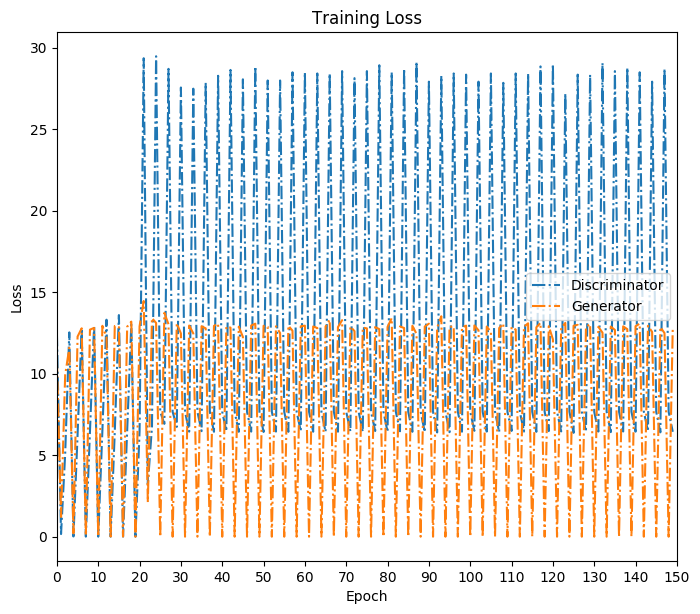

In [59]:
plot_gan(acgan)

Show three examples of photos generated of your first class.

In [52]:
noise = tf.random_normal(shape=(3, 100))
cls = tf.one_hot(tf.fill((3,), class_1_label), 10)
three_samples_1 = tf.reshape(acgan.G([noise, cls]), (-1, 28, 28))
three_samples_1 = (three_samples_1 + 1) * 127.5

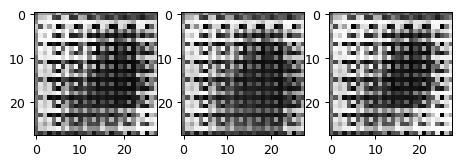

In [53]:
fig, axs = plt.subplots(1, 3, dpi=90)

for i in range(3):
    axs[i].imshow(three_samples_1[i], cmap="gray")

Show three examples of photos generated of your second class.

In [54]:
noise = tf.random_normal(shape=(3, 100))
cls = tf.one_hot(tf.fill((3,), class_2_label), 10)
three_samples_2 = tf.reshape(acgan.G([noise, cls]), (-1, 28, 28))
three_samples_2 = (three_samples_2 + 1) * 127.5

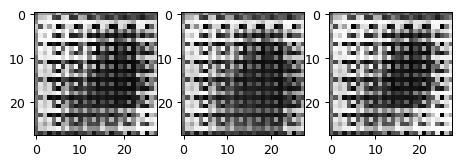

In [55]:
fig, axs = plt.subplots(1, 3, dpi=90)

for i in range(3):
    axs[i].imshow(three_samples_1[i], cmap="gray")